# 2-S3: Evidently 드리프트 기초

프로덕션 모델의 성능 저하 원인과 드리프트 개념을 학습합니다.

## 학습 목표
1. 왜 모델 성능이 떨어지는가?
2. **드리프트 3종류** (면접 필수!)
3. PSI (Population Stability Index) - 금융권 표준
4. Evidently 기초 사용법
5. include_tests (자동화 테스트)

## 예상 시간
- 약 1.5시간

## 선수 조건
- 2-S2 Model Registry 완료
- `pip install evidently pandas numpy`

In [4]:
# 패키지 설치 (필요시)
!pip install evidently pandas numpy matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")

패키지 로드 완료!


---
## 1. 왜 모델 성능이 떨어지는가?

### 1.1 현업 시나리오

```
[타임라인]

1월: FDS 모델 배포 (Recall 90%, AUC 0.91)
     └── "완벽해! 배포 성공!"

2월: 잘 동작 중...

3월: 고객 클레임 시작
     └── "요즘 이상거래가 자꾸 결제되네요?"

4월: 확인해보니 Recall이 70%로 급락! 😱
     └── 사기 100건 중 30건을 놓침
     └── 월 3000만원 손실 발생

왜?
```

### 1.2 "모델은 과거를 배우지만, 세상은 변한다"

ML 모델은 **학습 데이터의 패턴**을 배웁니다.

하지만 현실에서는:
- 고객 행동이 변함 (해외직구 증가)
- 새로운 사기 수법 등장 (딥페이크)
- 경제 상황 변화 (고액 거래 증가)
- 계절적 패턴 (연말 쇼핑)

**→ 학습 데이터와 실제 데이터의 분포가 달라짐**

**→ 이것을 드리프트(Drift)라고 부릅니다!**

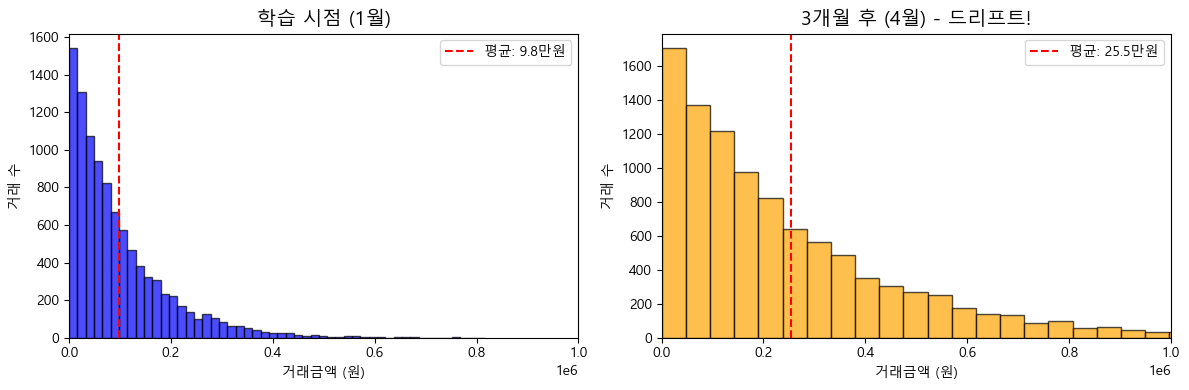

학습 시점 평균: 9.8만원
현재 시점 평균: 25.5만원
변화율: 160.5%

→ 분포가 완전히 다름! 이것이 드리프트!


In [5]:
# 📚 드리프트 시각화 예제

np.random.seed(42)

# 학습 시점의 거래금액 분포 (평균 10만원)
train_amounts = np.random.exponential(100000, 10000)

# 3개월 후 거래금액 분포 (평균 25만원으로 증가!)
current_amounts = np.random.exponential(250000, 10000)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 학습 시점
axes[0].hist(train_amounts, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(train_amounts.mean(), color='red', linestyle='--', label=f'평균: {train_amounts.mean()/10000:.1f}만원')
axes[0].set_title('학습 시점 (1월)', fontsize=14)
axes[0].set_xlabel('거래금액 (원)')
axes[0].set_ylabel('거래 수')
axes[0].legend()
axes[0].set_xlim(0, 1000000)

# 3개월 후
axes[1].hist(current_amounts, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(current_amounts.mean(), color='red', linestyle='--', label=f'평균: {current_amounts.mean()/10000:.1f}만원')
axes[1].set_title('3개월 후 (4월) - 드리프트!', fontsize=14)
axes[1].set_xlabel('거래금액 (원)')
axes[1].set_ylabel('거래 수')
axes[1].legend()
axes[1].set_xlim(0, 1000000)

plt.tight_layout()
plt.show()

print(f"학습 시점 평균: {train_amounts.mean()/10000:.1f}만원")
print(f"현재 시점 평균: {current_amounts.mean()/10000:.1f}만원")
print(f"변화율: {(current_amounts.mean() - train_amounts.mean()) / train_amounts.mean() * 100:.1f}%")
print("\n→ 분포가 완전히 다름! 이것이 드리프트!")

---
## 2. 드리프트 3종류 (면접 필수!)

### 2.1 드리프트 종류 개요

```
┌────────────────────────────────────────────────────────────┐
│                   드리프트 3종류                            │
├────────────────┬────────────────┬─────────────────────────┤
│ Covariate      │ Prior          │ Concept                 │
│ Shift          │ Probability    │ Drift                   │
│                │ Shift          │                         │
├────────────────┼────────────────┼─────────────────────────┤
│ 입력(X) 분포   │ 타겟(Y) 분포   │ X→Y 관계                │
│ 변화           │ 변화           │ 변화                    │
├────────────────┼────────────────┼─────────────────────────┤
│ 거래금액 증가  │ 사기 비율 증가 │ 해외거래 의미 변화      │
└────────────────┴────────────────┴─────────────────────────┘
```

### 2.2 Covariate Shift (입력 분포 변화)

**정의**: 입력 피처(X)의 분포가 변하는 현상

**FDS 예시:**
```
학습 시점:
- 거래금액 평균: 10만원
- 주간 거래 비율: 80%
- 국내 거래 비율: 95%

현재 시점:
- 거래금액 평균: 50만원 ← 연말 쇼핑 시즌
- 주간 거래 비율: 60% ← 야간 쇼핑 증가
- 국내 거래 비율: 70% ← 해외직구 증가
```

**왜 문제인가?**
- 모델이 "고액 거래 = 사기"로 학습했다면
- 고액 정상 거래도 사기로 판단 (오탐 증가)

In [6]:
# 📚 Covariate Shift 예시

print("=== Covariate Shift (입력 분포 변화) ===")
print()
print("[학습 데이터]")
print("  거래금액 분포: 1~20만원이 90%")
print("  모델 학습 결과: '고액 거래(50만원+) = 사기 가능성 높음'")
print()
print("[3개월 후 실제 데이터]")
print("  거래금액 분포: 10~50만원이 70%  ← 고액화")
print("  결과: 정상 고액 거래도 사기로 판단")
print("        → 오탐(False Positive) 급증!")
print()
print("핵심: X(입력)의 분포만 변함, Y와의 관계는 그대로")

=== Covariate Shift (입력 분포 변화) ===

[학습 데이터]
  거래금액 분포: 1~20만원이 90%
  모델 학습 결과: '고액 거래(50만원+) = 사기 가능성 높음'

[3개월 후 실제 데이터]
  거래금액 분포: 10~50만원이 70%  ← 고액화
  결과: 정상 고액 거래도 사기로 판단
        → 오탐(False Positive) 급증!

핵심: X(입력)의 분포만 변함, Y와의 관계는 그대로


### 2.3 Prior Probability Shift (타겟 분포 변화)

**정의**: 타겟(Y)의 분포가 변하는 현상

**FDS 예시:**
```
학습 시점:
- 사기 비율: 1% (100건 중 1건)

현재 시점:
- 사기 비율: 5% (100건 중 5건) ← 새 사기 수법 등장!
```

**왜 문제인가?**
- 모델의 threshold가 1% 기준으로 설정됨
- 사기가 5배 증가하면 탐지 못하는 케이스 증가
- Recall 급락!

In [7]:
# 📚 Prior Probability Shift 예시

print("=== Prior Probability Shift (타겟 분포 변화) ===")
print()
print("[학습 데이터]")
print("  사기 비율: 1% (10,000건 중 100건)")
print("  모델 threshold: 0.5 (확률 50% 이상이면 사기)")
print()
print("[3개월 후 실제 데이터]")
print("  사기 비율: 5% (10,000건 중 500건)  ← 5배 증가!")
print("  원인: 새로운 사기 수법 등장 (딥페이크, 피싱 등)")
print()
print("  결과: 모델이 학습하지 않은 새 패턴 탐지 실패")
print("        → Recall(탐지율) 급락!")
print()
print("핵심: Y(사기 비율)의 분포가 변함")

=== Prior Probability Shift (타겟 분포 변화) ===

[학습 데이터]
  사기 비율: 1% (10,000건 중 100건)
  모델 threshold: 0.5 (확률 50% 이상이면 사기)

[3개월 후 실제 데이터]
  사기 비율: 5% (10,000건 중 500건)  ← 5배 증가!
  원인: 새로운 사기 수법 등장 (딥페이크, 피싱 등)

  결과: 모델이 학습하지 않은 새 패턴 탐지 실패
        → Recall(탐지율) 급락!

핵심: Y(사기 비율)의 분포가 변함


### 2.4 Concept Drift (입력-출력 관계 변화)

**정의**: X와 Y 사이의 **관계 자체**가 변하는 현상

**FDS 예시:**
```
학습 시점 (2020년):
- 해외 결제 → 사기 가능성 높음 (해외 결제 드뭄)
- P(사기 | 해외결제) = 0.3

현재 시점 (2024년):
- 해외직구 일상화 → 해외 결제 = 정상
- P(사기 | 해외결제) = 0.05  ← 관계가 바뀜!
```

**왜 문제인가?**
- 같은 입력(해외결제)인데 의미가 완전히 다름
- 모델의 근본적인 가정이 무너짐
- **재학습 필수!**

In [8]:
# 📚 Concept Drift 예시

print("=== Concept Drift (입력-출력 관계 변화) ===")
print()
print("[학습 데이터 - 2020년]")
print("  해외 결제 → 사기 가능성 높음")
print("  이유: 해외 결제 자체가 드물었음")
print("  모델: '해외결제 = 위험 신호'로 학습")
print()
print("[현재 - 2024년]")
print("  해외직구 일상화 (알리, 테무 등)")
print("  해외 결제 → 대부분 정상 거래")
print()
print("  문제: 모델은 여전히 '해외결제 = 사기'로 판단")
print("        → 정상 해외직구를 모두 사기로 오탐!")
print()
print("핵심: X→Y 관계(조건부 확률) 자체가 변함")
print("      가장 심각한 드리프트 유형!")

=== Concept Drift (입력-출력 관계 변화) ===

[학습 데이터 - 2020년]
  해외 결제 → 사기 가능성 높음
  이유: 해외 결제 자체가 드물었음
  모델: '해외결제 = 위험 신호'로 학습

[현재 - 2024년]
  해외직구 일상화 (알리, 테무 등)
  해외 결제 → 대부분 정상 거래

  문제: 모델은 여전히 '해외결제 = 사기'로 판단
        → 정상 해외직구를 모두 사기로 오탐!

핵심: X→Y 관계(조건부 확률) 자체가 변함
      가장 심각한 드리프트 유형!


### 💻 실습 1: 드리프트 종류 구분

아래 상황이 어떤 드리프트인지 맞춰보세요.

In [9]:
# 💻 실습 1: 드리프트 종류 구분

# 각 상황에 해당하는 드리프트 종류를 입력하세요.
# "covariate", "prior", "concept" 중 하나

# 상황 1: 연말 쇼핑 시즌으로 거래금액이 평균 3배 증가
situation_1 = "covariate"  # TODO: 정답 입력

# 상황 2: 새로운 피싱 수법으로 사기 거래가 1%에서 8%로 증가
situation_2 = "prior"  # TODO: 정답 입력

# 상황 3: 과거에는 "새벽 거래 = 사기"였는데, 
#         요즘은 야간 쇼핑이 일상화되어 정상 거래가 많음
situation_3 = "concept"  # TODO: 정답 입력

print("상황 1 (거래금액 3배 증가):", situation_1)
print("상황 2 (사기 비율 1%→8%):", situation_2)
print("상황 3 (새벽거래 의미 변화):", situation_3)

상황 1 (거래금액 3배 증가): covariate
상황 2 (사기 비율 1%→8%): prior
상황 3 (새벽거래 의미 변화): concept


In [10]:
# 체크포인트 1
assert situation_1.lower() == "covariate", "상황 1: 입력(금액) 분포 변화 → Covariate Shift"
assert situation_2.lower() == "prior", "상황 2: 타겟(사기비율) 분포 변화 → Prior Probability Shift"
assert situation_3.lower() == "concept", "상황 3: 입력-출력 관계 변화 → Concept Drift"

print("✅ 체크포인트 1 통과!")
print("\n드리프트 3종류를 정확히 구분했습니다!")

✅ 체크포인트 1 통과!

드리프트 3종류를 정확히 구분했습니다!


---
## 3. PSI (Population Stability Index)

### 3.1 왜 PSI를 쓰는가?

**PSI는 금융권 표준 드리프트 지표입니다.**

- 금융권에서 15-20년간 사용된 업계 표준 (rule of thumb)
- 해석이 직관적 (0.25 기준)
- 다른 통계 검정(KS-test 등)보다 현업에서 이해하기 쉬움

> ⚠️ **참고**: 0.1/0.25 기준은 학술적 근거 없이 업계 관행으로 정착된 값입니다.

**PSI 해석 기준:**

| PSI 값 | 해석 | 조치 |
|--------|------|------|
| **< 0.1** | 안정 ✅ | 유지 |
| **0.1 ~ 0.25** | 약한 변화 ⚠️ | 모니터링 강화 |
| **> 0.25** | 심각한 드리프트 🚨 | **재학습 필요!** |

### 3.2 PSI 계산 원리 (간단 설명)

```
PSI = Σ (현재비율 - 기준비율) × ln(현재비율 / 기준비율)
```

**직관적 이해:**
1. 데이터를 여러 구간(bin)으로 나눔
2. 각 구간에 데이터가 얼마나 있는지 비율 계산
3. 기준(Reference)과 현재(Current) 비율 차이 측정
4. 모든 구간의 차이를 합산

```
예시: 거래금액 5개 구간

구간        기준비율    현재비율    차이
0~10만      30%        10%        큰 차이!
10~20만     25%        15%        차이 있음
20~30만     20%        25%        약간 차이
30~50만     15%        30%        큰 차이!
50만+       10%        20%        차이 있음

→ PSI = 각 차이의 가중 합 = 0.35 (드리프트!)
```

In [11]:
# 📚 PSI 계산 함수

def calculate_psi(reference, current, bins=10):
    """
    PSI (Population Stability Index) 계산
    
    Parameters:
    -----------
    reference : array-like
        기준 데이터 (학습 데이터)
    current : array-like
        현재 데이터 (비교 대상)
    bins : int
        구간 개수
    
    Returns:
    --------
    float : PSI 값
    """
    # 구간 경계 계산 (reference 기준)
    breakpoints = np.percentile(reference, np.linspace(0, 100, bins + 1))
    breakpoints[0] = -np.inf
    breakpoints[-1] = np.inf
    
    # 각 구간별 비율 계산
    ref_counts = np.histogram(reference, breakpoints)[0]
    cur_counts = np.histogram(current, breakpoints)[0]
    
    # 비율로 변환 (0 방지를 위해 작은 값 추가)
    ref_pct = (ref_counts + 1) / (len(reference) + bins)
    cur_pct = (cur_counts + 1) / (len(current) + bins)
    
    # PSI 계산
    psi = np.sum((cur_pct - ref_pct) * np.log(cur_pct / ref_pct))
    
    return psi

print("PSI 계산 함수 정의 완료!")

PSI 계산 함수 정의 완료!


In [12]:
# 📚 PSI 해석 함수

def interpret_psi(psi_value):
    """
    PSI 값 해석 (금융권 표준)
    """
    if psi_value < 0.1:
        return "안정 ✅ - 변화 없음"
    elif psi_value < 0.25:
        return "주의 ⚠️ - 모니터링 강화 필요"
    else:
        return "드리프트 🚨 - 재학습 필요!"

# 예시: 위에서 만든 데이터로 PSI 계산
psi_value = calculate_psi(train_amounts, current_amounts)

print(f"PSI = {psi_value:.4f}")
print(f"해석: {interpret_psi(psi_value)}")

PSI = 0.6795
해석: 드리프트 🚨 - 재학습 필요!


### 💻 실습 2: PSI 계산 및 해석

In [13]:
# 💻 실습 2: PSI 계산 및 해석

np.random.seed(123)

# 시나리오 A: 거의 변화 없음 (평균 10만원 → 11만원)
ref_a = np.random.exponential(100000, 5000)
cur_a = np.random.exponential(110000, 5000)  # 10% 증가

# 시나리오 B: 심각한 변화 (평균 10만원 → 40만원)
ref_b = np.random.exponential(100000, 5000)
cur_b = np.random.exponential(400000, 5000)  # 4배 증가

# TODO: PSI 계산
psi_a = calculate_psi(ref_a, cur_a)  # TODO
psi_b = calculate_psi(ref_b, cur_b)  # TODO

print("시나리오 A (10% 증가):")
print(f"  PSI = {psi_a:.4f}")
print(f"  해석: {interpret_psi(psi_a)}")
print()
print("시나리오 B (4배 증가):")
print(f"  PSI = {psi_b:.4f}")
print(f"  해석: {interpret_psi(psi_b)}")

시나리오 A (10% 증가):
  PSI = 0.0096
  해석: 안정 ✅ - 변화 없음

시나리오 B (4배 증가):
  PSI = 1.2982
  해석: 드리프트 🚨 - 재학습 필요!


In [14]:
# 체크포인트 2
assert psi_a < 0.25, "시나리오 A는 PSI < 0.25 (약한 변화)"
assert psi_b > 0.25, "시나리오 B는 PSI > 0.25 (심각한 드리프트)"

print("✅ 체크포인트 2 통과!")
print("\nPSI 0.25 기준을 정확히 이해했습니다!")

✅ 체크포인트 2 통과!

PSI 0.25 기준을 정확히 이해했습니다!


---
## 4. Evidently 기초

### 4.1 Reference vs Current 개념

Evidently는 **두 데이터셋을 비교**해서 드리프트를 감지합니다.

```
┌─────────────────┐      ┌─────────────────┐
│  Reference Data │      │  Current Data   │
│   (기준 데이터)  │  vs  │  (현재 데이터)   │
│                 │      │                 │
│  = 학습 데이터   │      │  = 최근 데이터   │
│  = "정상" 기준   │      │  = 비교 대상     │
└─────────────────┘      └─────────────────┘
          │                      │
          └──────────┬───────────┘
                     ↓
              분포 비교 (PSI 등)
                     ↓
              드리프트 여부 판정
```

| 파라미터 | 역할 | FDS 예시 |
|----------|------|----------|
| `reference_data` | 기준 데이터 | 모델 학습에 사용한 데이터 |
| `current_data` | 비교할 데이터 | 최근 1주일 거래 데이터 |

In [15]:
# 📚 Evidently 기본 사용법

import evidently
from evidently import Report
from evidently.presets import DataDriftPreset

print(f"Evidently 버전: {evidently.__version__}")

# 실습용 데이터 생성
np.random.seed(42)

# Reference 데이터 (학습 데이터)
reference_df = pd.DataFrame({
    'amount': np.random.exponential(100000, 1000),
    'hour': np.random.randint(9, 22, 1000),  # 9시~22시
    'is_foreign': np.random.choice([0, 1], 1000, p=[0.95, 0.05])
})

# Current 데이터 (드리프트 있음)
current_df = pd.DataFrame({
    'amount': np.random.exponential(300000, 1000),  # 금액 3배 증가
    'hour': np.random.randint(0, 24, 1000),  # 24시간 분포
    'is_foreign': np.random.choice([0, 1], 1000, p=[0.70, 0.30])  # 해외 30%
})

print("\nReference 데이터:")
print(reference_df.describe())
print("\nCurrent 데이터:")
print(current_df.describe())

Evidently 버전: 0.7.19

Reference 데이터:
              amount        hour   is_foreign
count    1000.000000  1000.00000  1000.000000
mean    97250.594797    15.15000     0.054000
std     97250.988616     3.81314     0.226131
min       464.278407     9.00000     0.000000
25%     26915.652932    12.00000     0.000000
50%     68678.261725    15.00000     0.000000
75%    136383.020860    18.00000     0.000000
max    817244.559782    21.00000     1.000000

Current 데이터:
             amount         hour  is_foreign
count  1.000000e+03  1000.000000  1000.00000
mean   2.977718e+05    11.941000     0.29400
std    2.945398e+05     6.770329     0.45582
min    3.490447e+00     0.000000     0.00000
25%    8.619265e+04     6.000000     0.00000
50%    2.082457e+05    12.000000     0.00000
75%    4.137681e+05    18.000000     1.00000
max    2.041725e+06    23.000000     1.00000


In [16]:
# 📚 DataDriftPreset 사용법

# 1. Report 객체 생성
report = Report(metrics=[
    DataDriftPreset()  # 데이터 드리프트 분석 프리셋
])

# 2. 리포트 실행
result = report.run(
    reference_data=reference_df,
    current_data=current_df
)

print("✅ 드리프트 리포트 생성 완료!")
print("\n결과 객체 타입:", type(result))

✅ 드리프트 리포트 생성 완료!

결과 객체 타입: <class 'evidently.core.report.Snapshot'>


In [17]:
# 📚 결과 확인 방법

# 1. 딕셔너리로 변환
result_dict = result.dict()

# 2. 메트릭 결과 확인
print("=== 드리프트 분석 결과 ===")
print(f"\n메트릭 수: {len(result_dict.get('metrics', []))}")

# 3. HTML 저장 (선택)
# result.save_html("drift_report.html")

print("\n주요 메서드:")
print("  result.dict()       → 딕셔너리로 변환")
print("  result.json()       → JSON 문자열")
print("  result.save_html()  → HTML 파일 저장")

=== 드리프트 분석 결과 ===

메트릭 수: 4

주요 메서드:
  result.dict()       → 딕셔너리로 변환
  result.json()       → JSON 문자열
  result.save_html()  → HTML 파일 저장


In [18]:
# 체크포인트 3
assert result is not None, "Report 실행 필요"
assert 'metrics' in result_dict, "결과에 metrics가 있어야 함"

print("✅ 체크포인트 3 통과!")
print("\nEvidently Report 기본 사용법을 익혔습니다!")

✅ 체크포인트 3 통과!

Evidently Report 기본 사용법을 익혔습니다!


---
## 5. include_tests (Evidently 0.7+)

### 5.1 구버전 vs 신버전

**Evidently 0.7.0부터 TestSuite가 Report에 통합**되었습니다.

```python
# [구버전 0.6.x] - deprecated
from evidently.test_suite import TestSuite  # ❌ 더 이상 권장 안 함

# [신버전 0.7+] - 권장
report = Report(
    metrics=[DataDriftPreset()],
    include_tests=True  # ✅ 테스트 자동 포함!
)
```

**include_tests=True의 장점:**
1. 한 번의 실행으로 분석 + 테스트
2. Reference 데이터 기반 자동 임계값 설정
3. Pass/Fail 결과로 CI/CD 연동 가능

In [19]:
# 📚 include_tests 사용법

# Report + Tests (신버전 0.7+)
test_report = Report(
    metrics=[DataDriftPreset()],
    include_tests=True  # ← 테스트 자동 포함!
)

# 드리프트 있는 데이터로 테스트
test_result = test_report.run(
    reference_data=reference_df,
    current_data=current_df
)

print("✅ Report + Tests 실행 완료!")

✅ Report + Tests 실행 완료!


In [20]:
# 📚 테스트 결과 확인

test_dict = test_result.dict()

# tests 배열에서 결과 확인
tests_info = test_dict.get('tests', [])

if tests_info:
    passed = sum(1 for t in tests_info if t.get('status') == 'SUCCESS')
    failed = sum(1 for t in tests_info if t.get('status') == 'FAIL')
    
    print("=== 테스트 결과 ===")
    print(f"\n전체 테스트: {len(tests_info)}개")
    print(f"통과: {passed}개")
    print(f"실패: {failed}개")
    print(f"\n전체 통과: {'예 ✅' if failed == 0 else '아니오 ❌'}")
    
    if failed > 0:
        print("\n→ 드리프트 감지! 재학습 검토 필요")
else:
    print("테스트 결과 없음 (include_tests=True 확인)")

=== 테스트 결과 ===

전체 테스트: 4개
통과: 0개
실패: 4개

전체 통과: 아니오 ❌

→ 드리프트 감지! 재학습 검토 필요


In [21]:
# 💻 실습 4: 드리프트 없는 데이터로 테스트

# 드리프트 없는 Current 데이터 (Reference와 비슷한 분포)
np.random.seed(99)
no_drift_current = pd.DataFrame({
    'amount': np.random.exponential(105000, 1000),  # 거의 동일
    'hour': np.random.randint(9, 22, 1000),
    'is_foreign': np.random.choice([0, 1], 1000, p=[0.93, 0.07])
})

# TODO: Report + Tests 실행
no_drift_report = Report(
    metrics=[DataDriftPreset()],
    include_tests=True
)

no_drift_result = no_drift_report.run(
    reference_data=reference_df,
    current_data=no_drift_current  # 드리프트 없는 데이터
)

# 결과 확인
no_drift_dict = no_drift_result.dict()
no_drift_tests = no_drift_dict.get('tests', [])

if no_drift_tests:
    failed_count = sum(1 for t in no_drift_tests if t.get('status') == 'FAIL')
    print(f"실패한 테스트: {failed_count}개")
    print(f"드리프트 감지: {'예 🚨' if failed_count > 0 else '아니오 ✅'}")
else:
    print("테스트 결과 확인 필요")

실패한 테스트: 1개
드리프트 감지: 예 🚨


In [22]:
# 체크포인트 4
assert no_drift_result is not None, "테스트 실행 필요"

print("✅ 체크포인트 4 통과!")
print("\ninclude_tests 사용법을 익혔습니다!")

✅ 체크포인트 4 통과!

include_tests 사용법을 익혔습니다!


---
## 6. FDS 모니터링 지표

### 6.1 FDS에서 모니터링할 것들

```
[FDS 모니터링 대시보드]

1. 데이터 드리프트 (Evidently) ← 오늘 배운 것!
   - 거래금액 분포 변화 (PSI)
   - 시간대별 거래 패턴 변화
   - 해외거래 비율 변화

2. 모델 성능 (일간/주간)
   - Recall (탐지율) ← 가장 중요!
   - AUPRC
   - 비용 지표 (FN×100만 + FP×5만)

3. 시스템 메트릭 (Prometheus) ← 2-6에서 배움
   - API 응답 시간 (p50, p95, p99)
   - 요청 처리량 (RPS)
   - 에러율
```

In [23]:
# 📚 모니터링 주기 권장

print("=== FDS 드리프트 모니터링 권장 주기 ===")
print()
print("| 모니터링 항목 | 주기 | 임계값 | 조치 |")
print("|--------------|------|--------|------|")
print("| 데이터 드리프트 | 매일 | PSI > 0.25 | 알림 → 분석 |")
print("| 타겟 드리프트 | 매주 | 비율 변화 > 50% | 알림 → 원인 파악 |")
print("| 모델 성능 | 매주 | Recall 하락 > 5% | 재학습 검토 |")
print()
print("자동화 파이프라인 예시:")
print("  매일 00:00 (Airflow/Cron)")
print("      ↓")
print("  데이터 수집 (최근 24시간)")
print("      ↓")
print("  include_tests=True로 테스트")
print("      ↓")
print("  Pass → 로그 기록")
print("  Fail → Slack 알림 + Report 생성")

=== FDS 드리프트 모니터링 권장 주기 ===

| 모니터링 항목 | 주기 | 임계값 | 조치 |
|--------------|------|--------|------|
| 데이터 드리프트 | 매일 | PSI > 0.25 | 알림 → 분석 |
| 타겟 드리프트 | 매주 | 비율 변화 > 50% | 알림 → 원인 파악 |
| 모델 성능 | 매주 | Recall 하락 > 5% | 재학습 검토 |

자동화 파이프라인 예시:
  매일 00:00 (Airflow/Cron)
      ↓
  데이터 수집 (최근 24시간)
      ↓
  include_tests=True로 테스트
      ↓
  Pass → 로그 기록
  Fail → Slack 알림 + Report 생성


---
## 7. 최종 요약

In [ ]:
print("="*60)
print("  2-S3 완료: Evidently 드리프트 기초")
print("="*60)
print()
print("배운 것:")
print()
print("1. 왜 모델 성능이 떨어지는가?")
print("   - 학습 데이터와 실제 데이터의 분포 차이")
print("   - 시간이 지나면 반드시 발생")
print()
print("2. 드리프트 3종류 (면접 필수!)")
print("   - Covariate Shift: 입력(X) 분포 변화")
print("   - Prior Probability Shift: 타겟(Y) 분포 변화")
print("   - Concept Drift: X->Y 관계 변화 (가장 심각)")
print()
print("3. PSI (Population Stability Index)")
print("   - 금융권 표준 드리프트 지표")
print("   - < 0.1: 안정")
print("   - 0.1~0.25: 모니터링 강화")
print("   - > 0.25: 재학습 필요!")
print()
print("4. Evidently 기초")
print("   - Reference vs Current 개념")
print("   - DataDriftPreset 사용")
print("   - Report.run() API")
print()
print("5. include_tests (Evidently 0.7+)")
print("   - TestSuite -> Report 통합")
print("   - Pass/Fail로 자동화 가능")
print()
print("="*60)
print("다음: 2-S4 비용 최적화 + CI/CD로!")
print("="*60)

### 학습 체크리스트

| 항목 | 이해도 |
|------|--------|
| **드리프트 3종류 구분 (면접!)** | ☐ |
| PSI 해석 기준 (0.25) | ☐ |
| Reference vs Current 개념 | ☐ |
| Evidently Report 사용법 | ☐ |
| include_tests 사용법 | ☐ |

### 면접 예상 질문

**1. "데이터 드리프트의 3가지 종류를 설명해주세요."** ⭐

답변:
- **Covariate Shift**: 입력 피처(X)의 분포가 변하는 현상. 예: 거래금액 평균이 10만원에서 50만원으로 증가.
- **Prior Probability Shift**: 타겟(Y)의 분포가 변하는 현상. 예: 사기 비율이 1%에서 5%로 증가.
- **Concept Drift**: 입력과 출력 사이의 관계(P(Y|X))가 변하는 현상. 예: 해외결제가 과거에는 사기 신호였지만, 해외직구 일상화로 정상 거래가 됨.

---

**2. "PSI 0.25가 의미하는 것은 무엇인가요?"**

답변:
- PSI(Population Stability Index)는 **금융권 표준** 드리프트 지표입니다.
- PSI < 0.1: 안정 (변화 없음)
- PSI 0.1~0.25: 약한 변화 (모니터링 강화)
- **PSI > 0.25: 심각한 드리프트 → 재학습 필요**
- 금융권에서 15-20년간 사용된 업계 표준입니다. (학술적 근거는 없으나 실무에서 널리 통용)

---

**3. "드리프트를 감지하면 어떻게 대응하나요?"**

답변:
- **1단계 - 알림**: Slack/이메일로 담당자에게 즉시 알림
- **2단계 - 분석**: Evidently Report로 어떤 피처가 드리프트됐는지 확인
- **3단계 - 조치**:
  - PSI < 0.3: 모니터링 주기 단축
  - PSI > 0.3: 재학습 파이프라인 트리거
  - 긴급 시: 룰 기반 fallback 모델로 전환